# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their (gu)estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this, and not to correct any measurement once written down.

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 21-11-2024 (latest update)

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from iminuit import Minuit, cost
from scipy import stats
from scipy import special

Options for the program: 

In [2]:
blinded = True            # Add a random (but fixed) offset to the 30cm and 2m data seperately
save_plots = False

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constant to all measurements. This is a good way of working, as we then don't get affected by prior beliefs. Note that a different blinding constant is added for the 30cm ruler and 2m folding rule measurements, so that only after unblinding can the correspondence between the two be considered as a vital cross check.

In [3]:
if blinded:
    blinding30cm = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
    blinding2m   = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding30cm = 0
    blinding2m = 0

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [4]:
infiles = ["data_TableMeasurements2024.txt",
           "data_TableMeasurements2023.txt",
           "data_TableMeasurements2022.txt",
           "data_TableMeasurements2021.txt",
           "data_TableMeasurements2020.txt",
           "data_TableMeasurements2019.txt",
           "data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files (and print the values as a cross check):

In [5]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([])

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    # Note that blinding is applied before storing the values read:
    L30cm = np.append(L30cm, tmp_L30cm + blinding30cm)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding2m)
    eL2m = np.append(eL2m, tmp_eL2m)

N_read  = len(L30cm)       # Number of measurements read in total
print(f"\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")


Read all 16 file(s) which included 913 measurements. 



### First thing: Plot the data!

It is paramount that one plots data - it is the only way to get a good sense of it.

To get a feel for the resolutions involved, I also give a rough estimate of the peak resolutions.

  Estimates of the peak resolution:   30cm: 0.0130   2m: 0.0037


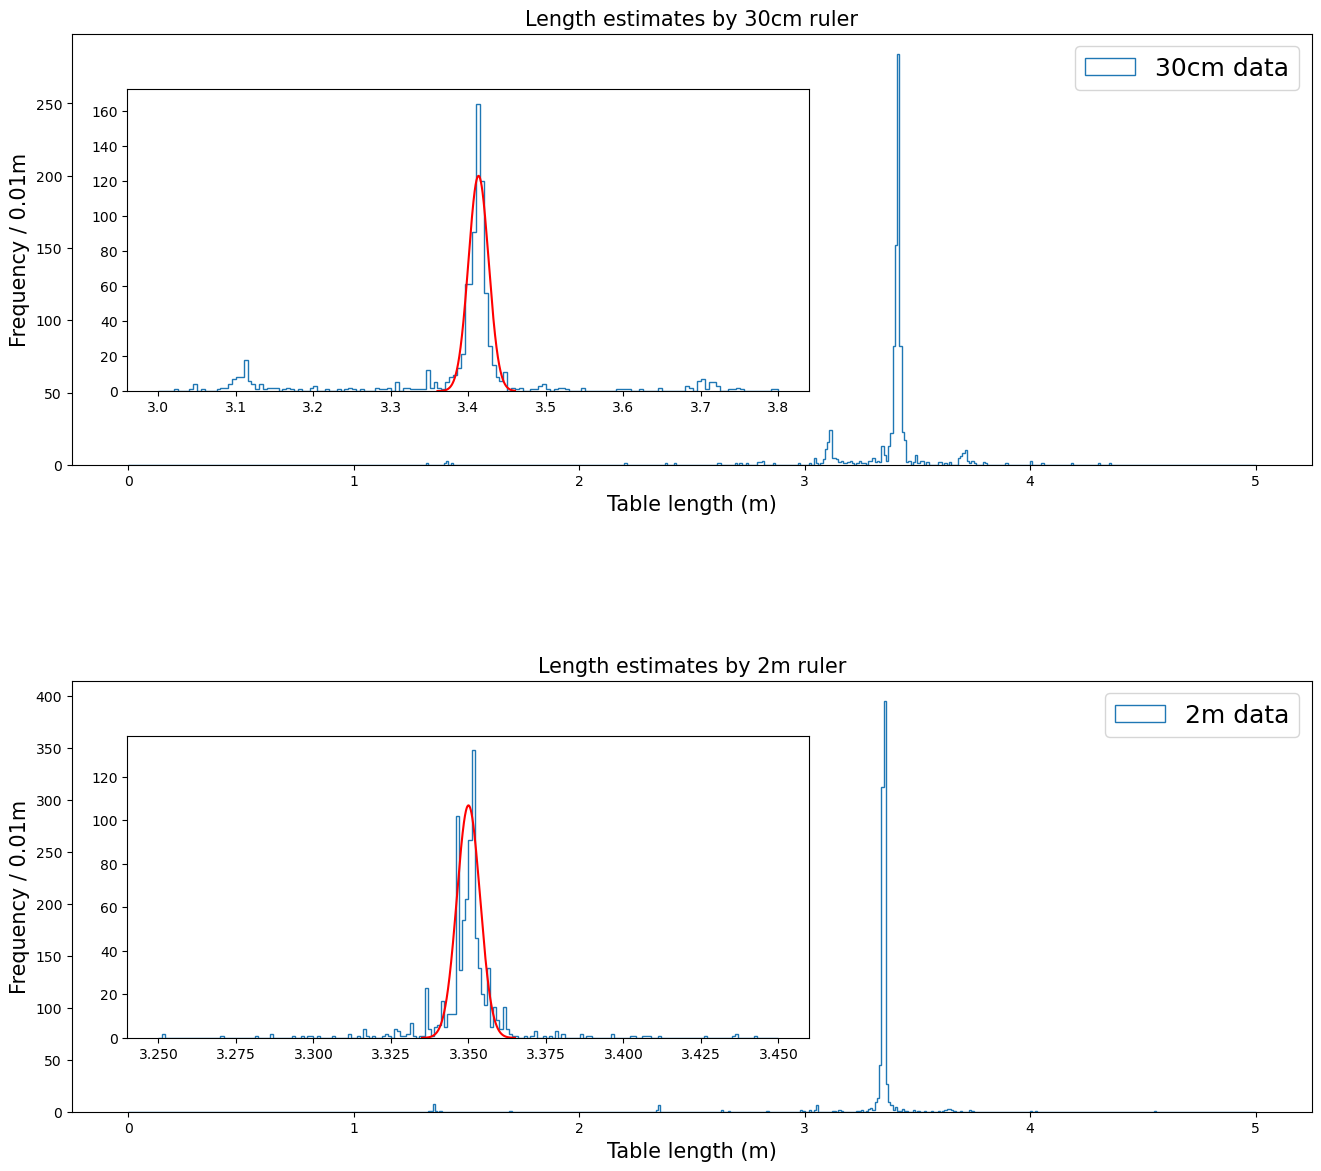

In [6]:
# Carefully consider binning - subplots/inserts are defintely worth considering!
NbinsE = 500
minE = 0.0
maxE = 5.0
binwidth = (maxE-minE) / NbinsE

# Single Gaussian (for drawing):
def func_Gaussian(x, N, mu, sigma) :
    return N * binwidth / np.sqrt(2*np.pi) / sigma * np.exp(-0.5*((x-mu)/sigma)**2)

# Estimate the measurement resolutions for good measurements:
std30cm = np.array(L30cm)[(3.36 < np.abs(L30cm)) & (np.abs(L30cm) < 3.46)].std(ddof=1)
std2m   = np.array(L2m)[(3.34 < np.abs(L2m)) & (np.abs(L2m) < 3.36)].std(ddof=1)
print(f"  Estimates of the peak resolution:   30cm: {std30cm:6.4f}   2m: {std2m:6.4f}")

# Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=NbinsE, range=(minE, maxE), histtype='step', label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L30cm.set_xlabel('Table length (m)',fontsize=15)
sub_ax_L30cm = inset_axes(parent_axes=ax_L30cm, width="55%", height="70%", loc="upper left", borderpad=4)
sub_ax_L30cm.hist(L30cm, bins=160, range=(3.0, 3.8), histtype='step', label='30cm data')
xaxis = np.linspace(3.36, 3.46, 1000)
sub_ax_L30cm.plot(xaxis, func_Gaussian(xaxis, 400, 3.413, std30cm), '-r', label="Approx. Gaussian")
ax_L30cm.legend(fontsize=18)

hist_L2m = ax_L2m.hist(L2m, bins=NbinsE, range=(minE, maxE), histtype='step', label='2m data')
ax_L2m.set_title('Length estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency / 0.01m',fontsize=15)
ax_L2m.set_xlabel('Table length (m)',fontsize=15)
sub_ax_L2m = inset_axes(parent_axes=ax_L2m, width="55%", height="70%", loc="upper left", borderpad=4)
sub_ax_L2m.hist(L2m, bins=200, range=(3.25, 3.45), histtype='step', label='2m data')
xaxis = np.linspace(3.335, 3.365, 1000)
sub_ax_L2m.plot(xaxis, func_Gaussian(xaxis, 100, 3.35, std2m), '-r', label="Approx. Gaussian")
ax_L2m.legend(fontsize=18)

fig_raw.tight_layout;

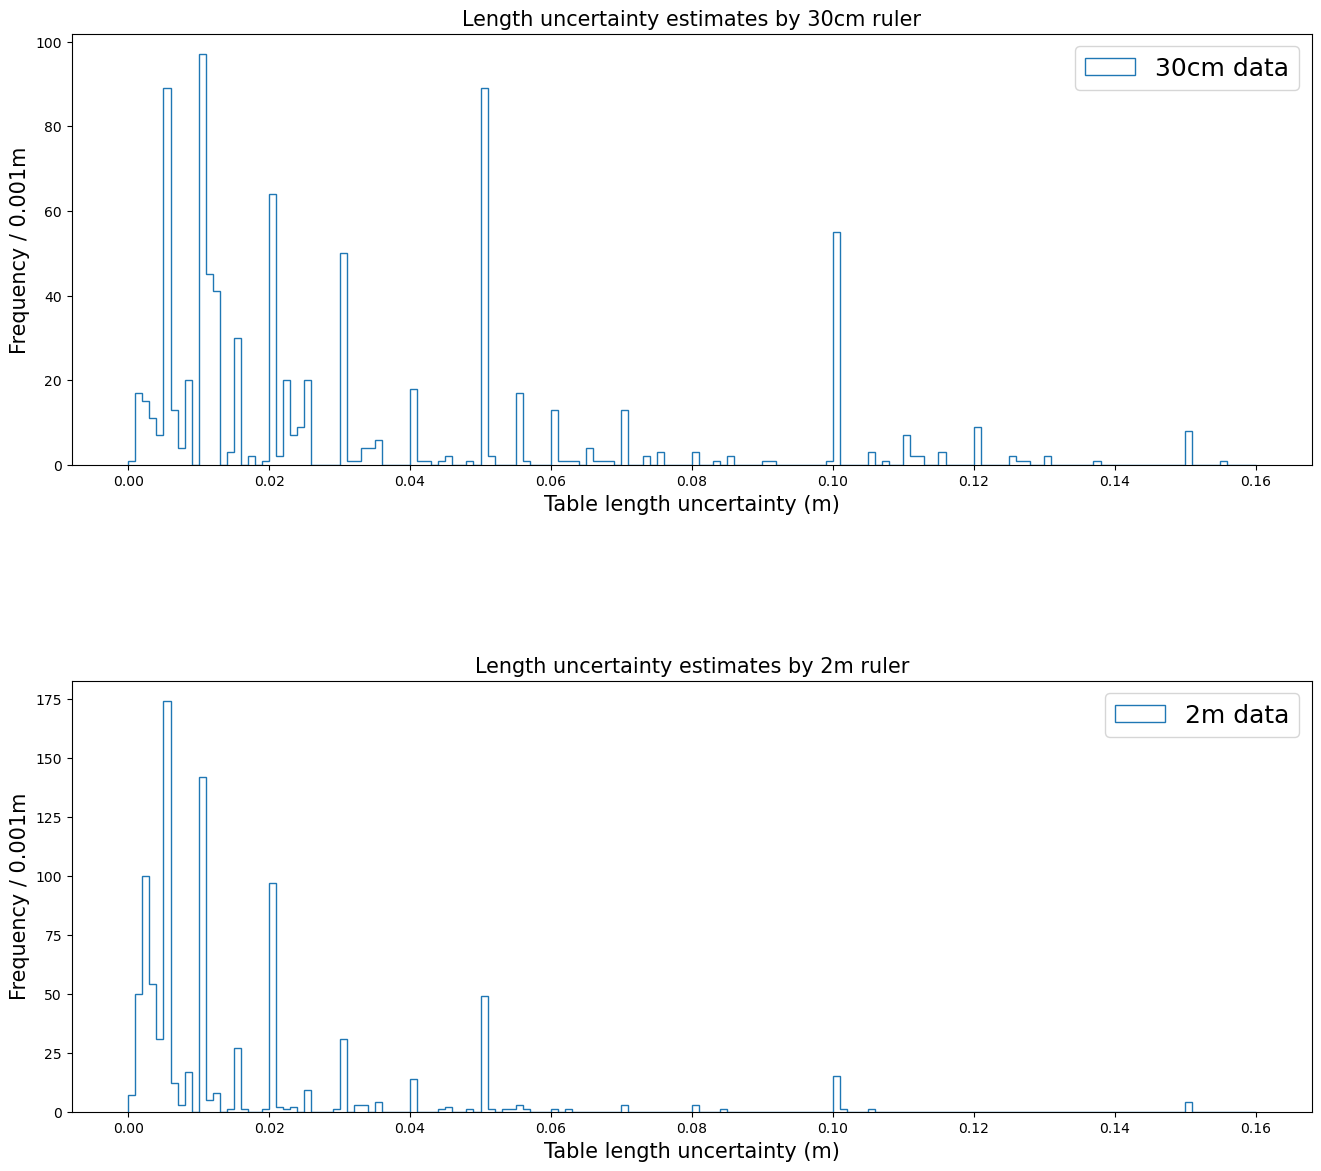

In [7]:
# Carefully consider binning - subplots/inserts are defintely worth considering!
NbinsE = 160
minE = 0.0
maxE = 0.16

# Define two histograms with all the length uncertainties recorded:
fig_errors, ax = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(eL30cm, bins=NbinsE, range=(minE, maxE), histtype='step', label='30cm data')
ax_L30cm.set_title('Length uncertainty estimates by 30cm ruler',fontsize=15)
ax_L30cm.set_ylabel('Frequency / 0.001m',fontsize=15)
ax_L30cm.set_xlabel('Table length uncertainty (m)',fontsize=15)
ax_L30cm.legend(fontsize=18)

hist_L2m = ax_L2m.hist(eL2m, bins=NbinsE, range=(minE, maxE), histtype='step', label='2m data')
ax_L2m.set_title('Length uncertainty estimates by 2m ruler',fontsize=15)
ax_L2m.set_ylabel('Frequency / 0.001m',fontsize=15)
ax_L2m.set_xlabel('Table length uncertainty (m)',fontsize=15)
ax_L2m.legend(fontsize=18)

fig_errors.tight_layout;

## Check the validity of the measurements:

In [8]:
# For the unweighted measurement, we define "valid" as in the range 0.0m < measurement < 6.0m:
L30cm_valid_uw = []
for entry in L30cm :
    if (0.0 < entry < 6.0) : L30cm_valid_uw.append(entry)
    else : print(f"  The 30cm entry L = {entry:6.3f} was not considered valid!")

L2m_valid_uw = []
for entry in L2m :
    if (0.0 < entry < 6.0) : L2m_valid_uw.append(entry)
    else : print(f"  The 2m entry L = {entry:6.3f} was not considered valid!")

  The 2m entry L = -1.014 was not considered valid!
  The 2m entry L = -1.014 was not considered valid!


# "Naive" analysis:

We consider the valid measurements, and simply calculate the mean and its uncertainty.


In [9]:
print(f"  Initial estimate of raw data (30 cm ruler):    " +
      f"  {np.mean(L30cm_valid_uw):.4f} +- {np.std(L30cm_valid_uw, ddof=1)/np.sqrt(len(L30cm_valid_uw)):.4f} m " +
      f"  (Std = {np.std(L30cm_valid_uw, ddof=1):.3f})   (Nmeasurements = {len(L30cm_valid_uw):3d})")
print(f"  Initial estimate of raw data (2m folding rule):" +
      f"  {np.mean(L2m_valid_uw):.4f} +- {np.std(L2m_valid_uw, ddof=1)/np.sqrt(len(L2m_valid_uw)):.4f} m " +
      f"  (Std = {np.std(L2m_valid_uw, ddof=1):.3f})   (Nmeasurements = {len(L2m_valid_uw):3d})")

  Initial estimate of raw data (30 cm ruler):      3.3750 +- 0.0077 m   (Std = 0.232)   (Nmeasurements = 913)
  Initial estimate of raw data (2m folding rule):  3.3154 +- 0.0086 m   (Std = 0.259)   (Nmeasurements = 911)


Somehow, the Std doesn't seem optimal/right for either analysis... as a 23 or 26 cm uncertainty is rather large!

### Next steps:

From the above, you should by now be aware, that there is definitely room for improvement, due to some poor measurement. You want to exclude (or correct?) these, but remember, you should be able to argue for each and every point you remove or correct.

In fact, make sure that PRINT OUT EVERY MEASUREMENT THAT YOU EXCLUDE, along with numbers arguing their case! Barlow 4.2.3 (and the note above this very short section) along with Chauvenet's Criterion might serve as guidelines.

It is now up to you to select in (based on solid **quantified** arguments) the data, and subsequently produce a better estimate of the length of the table in world famous Auditorium A. Good luck...

# Unweighted measurement analysis:

This part of the analysis does not include the uncertainties of the measurements. Therefore, the correctness of the measurements have to be judged from the overall distribution of measurements (Chauvenet's Criterion).

In [10]:
# Apply Chauvenet's Criterion to a list and return (possibly) reduced list:
def ChauvenetsCriterion( inlist, pmin = 0.05, CCverbose = True) :

    if (type(inlist) is not list) :
        print(f"Error: Input to function ChauvenentsCriterion is NOT a list!")
        return [-9999999999.9, -99999999999.9]

    outlist = [entry for entry in inlist]
    mean, std = np.mean(inlist), np.std(inlist)   # Calculation of initial mean and rms.
    
    # Loop over the following iterations, until the furthest outlier is probably enough (p_any_outliers > pmin):
    while True :
        # Find the furthers outlier, i.e. most distant measurement from mean (least probable) and its index:
        ifurthest  = 0
        dLfurthest = 0.0
        for number, entry in enumerate( outlist ) :
            if (abs(entry - mean) > dLfurthest) :
                ifurthest = number                       # Note the index, so that this entry can later be removed!
                dLfurthest = abs(entry - mean)

        # Calculate the probability of any such outliers (taking into account that there are many measurements!):
        Nsigma_outlier = dLfurthest / std
        p_this_outlier = special.erfc(Nsigma_outlier / np.sqrt(2)) / 2.0
        p_any_outliers = 1.0 - (1.0 - p_this_outlier)**int(len(outlist))

        if (CCverbose) :
            print(f" {ifurthest:3d}: L={outlist[ifurthest]:5.3f}  dL={dLfurthest:5.3f}  Nsig={Nsigma_outlier:5.2f}" +
                  f" p_loc={p_this_outlier:10.8f}  p_glob={p_any_outliers:10.8f} >? pmin={pmin:5.3f}   N={len(outlist):3d}" +
                  f" mean={mean:6.4f}  std={std:6.4f}", end="")
            
        # Key line: If the furthest outlier is probably enough, then stop rejecting points:
        if (p_any_outliers > pmin) :
            if (CCverbose) : print(f"  -> Accepted")
            break

        # Remove the furthest point from the list of accepted measurements (if any are left!),
        # Recalculate mean and RMS, and finally reiterate:
        if (len(outlist) > 1) :
            if (CCverbose) : print(f"  -> Rejected")
            outlist.pop(ifurthest)
            mean, std = np.mean(outlist), np.std(outlist)
        else :
            print(f"\n  ERROR: All measurements have been rejected!")
            break

    print(f"  The number of accepted / rejected points is {len(outlist)} / {len(inlist)-len(outlist)}")
    return outlist

In [11]:
Verbose = True
ApplyChauvenetsCriterion = True
p_global = 0.10

if (ApplyChauvenetsCriterion) :
    # NOTE: The last number is the cut on p-value at which we accept the outermost point. 
    if (Verbose) : print("\n  ------------------   Chauvenet's Criterion (30cm)  ------------------  ")
    L30cm_accepted_uw = ChauvenetsCriterion( L30cm_valid_uw, p_global, True)
    if (Verbose) : print("\n  ------------------   Chauvenet's Criterion (2m)  ------------------  ")
    L2m_accepted_uw   = ChauvenetsCriterion( L2m_valid_uw, p_global, True)


  ------------------   Chauvenet's Criterion (30cm)  ------------------  
 600: L=1.325  dL=2.050  Nsig= 8.85 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=913 mean=3.3750  std=0.2317  -> Rejected
  61: L=1.405  dL=1.973  Nsig= 8.90 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=912 mean=3.3773  std=0.2216  -> Rejected
  97: L=1.413  dL=1.967  Nsig= 9.28 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=911 mean=3.3795  std=0.2119  -> Rejected
 552: L=1.415  dL=1.967  Nsig= 9.75 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=910 mean=3.3816  std=0.2017  -> Rejected
 829: L=1.420  dL=1.964  Nsig=10.28 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=909 mean=3.3838  std=0.1910  -> Rejected
 189: L=1.434  dL=1.952  Nsig=10.87 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=908 mean=3.3859  std=0.1796  -> Rejected
 162: L=2.206  dL=1.182  Nsig= 7.05 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=907 mean=3.3881  std=0.1676  -> Rejected
 261: L=

## First results:

Given that we have now made a first pass at removing what appears to be faulty measurements, we consider the (blinded) results:

In [12]:
uwmean30cm = np.mean(L30cm_accepted_uw)
euwmean30cm = np.std(L30cm_accepted_uw, ddof=1) / np.sqrt(len(L30cm_accepted_uw))
uwmean2m = np.mean(L2m_accepted_uw)
euwmean2m = np.std(L2m_accepted_uw, ddof=1) / np.sqrt(len(L2m_accepted_uw))

print(f"  Estimate using accepted data (30 cm ruler):    " +
      f"  {uwmean30cm:.5f} +- {euwmean30cm:.5f} m " +
      f"  (Std = {np.std(L30cm_accepted_uw, ddof=1):.4f})   (Nmeasurements = {len(L30cm_accepted_uw):3d})")
print(f"  Estimate using accepted data (2m folding rule):" +
      f"  {uwmean2m:.5f} +- {euwmean2m:.5f} m " +
      f"  (Std = {np.std(L2m_accepted_uw, ddof=1):.4f})   (Nmeasurements = {len(L2m_accepted_uw):3d})")

  Estimate using accepted data (30 cm ruler):      3.39438 +- 0.00404 m   (Std = 0.1200)   (Nmeasurements = 883)
  Estimate using accepted data (2m folding rule):  3.34942 +- 0.00020 m   (Std = 0.0055)   (Nmeasurements = 779)


## Problem with 30cm result:

While the 2m result is now rather accurate, the 30cm result has problems. This is due to the (many) mis-measurements of $\pm$30cm, which are not rejected by the Chauvenet's Criterion with p_global = 0.10. At least two solutions exist:
1. Decide to **reject** all measurements more than 15cm away from the mean, and run Chauvenet's Criterion again.
2. Decide to **correct** measurements 15-45cm away from the mean, and run Chauvenet's Criterion again.

The choice of correcting or rejecting is not a simple one, and it depends on the situation.
Ideally, one would try both (and several criteria for rejecting points) and then observe how
the final results vary with these (systematic) choices.

Note that in principle one could also correct the few obviously faulty 2m measurements.

## Solution for 30cm measurement rejecting (i.e. cleaning) measurements:

In [13]:
mean30cm = np.mean(L30cm_accepted_uw)    # Using the accepted measurements, as this is the best current estimate!

mask15cm = np.abs(L30cm_valid_uw - mean30cm) < 0.15
L30cm_cleaned15cm = np.array(L30cm_valid_uw)[mask15cm]
print(f"  Number of measurements outside +-15cm:  {len(L30cm_valid_uw)-len(L30cm_cleaned15cm)}")
print(f"  Number of measurements inside  +-15cm:  {len(L30cm_cleaned15cm)}")

if (ApplyChauvenetsCriterion) :
    if (Verbose) : print("\n  ------------------   Chauvenet's Criterion (30cm)  ------------------  ")
    L30cm_cleaned_uw = ChauvenetsCriterion( L30cm_cleaned15cm.tolist(), p_global, True)

  Number of measurements outside +-15cm:  172
  Number of measurements inside  +-15cm:  741

  ------------------   Chauvenet's Criterion (30cm)  ------------------  
  14: L=3.250  dL=0.159  Nsig= 5.51 p_loc=0.00000002  p_glob=0.00001365 >? pmin=0.100   N=741 mean=3.4091  std=0.0290  -> Rejected
 168: L=3.250  dL=0.160  Nsig= 5.63 p_loc=0.00000001  p_glob=0.00000685 >? pmin=0.100   N=740 mean=3.4093  std=0.0284  -> Rejected
 403: L=3.255  dL=0.155  Nsig= 5.57 p_loc=0.00000001  p_glob=0.00000921 >? pmin=0.100   N=739 mean=3.4095  std=0.0278  -> Rejected
 494: L=3.265  dL=0.145  Nsig= 5.33 p_loc=0.00000005  p_glob=0.00003598 >? pmin=0.100   N=738 mean=3.4097  std=0.0272  -> Rejected
  45: L=3.281  dL=0.129  Nsig= 4.84 p_loc=0.00000064  p_glob=0.00047449 >? pmin=0.100   N=737 mean=3.4099  std=0.0267  -> Rejected
 110: L=3.281  dL=0.129  Nsig= 4.92 p_loc=0.00000042  p_glob=0.00031208 >? pmin=0.100   N=736 mean=3.4101  std=0.0263  -> Rejected
  11: L=3.290  dL=0.121  Nsig= 4.66 p_loc=0.000

In [14]:
print(f"  Estimate using cleaned data (30 cm ruler):    " +
      f"  {np.mean(L30cm_cleaned_uw):.5f} +- {np.std(L30cm_cleaned_uw, ddof=1)/np.sqrt(len(L30cm_cleaned_uw)):.5f} m " +
      f"  (Std = {np.std(L30cm_cleaned_uw, ddof=1):.4f})   (Nmeasurements = {len(L30cm_cleaned_uw):3d})")

  Estimate using cleaned data (30 cm ruler):      3.41190 +- 0.00049 m   (Std = 0.0126)   (Nmeasurements = 677)


## Solution for 30cm measurement correcting measurements:

In [15]:
Ncorr30cm = 0
mean30cm = np.mean(L30cm_accepted_uw)    # Using the accepted measurements, as this is the best current estimate!
L30cm_corrected = []
for entry in L30cm_valid_uw :
    if (mean30cm-0.45 < entry < mean30cm-0.15) :
        L30cm_corrected.append(entry+0.30)
        Ncorr30cm += 1
    elif (mean30cm+0.15 < entry < mean30cm+0.45) :
        L30cm_corrected.append(entry-0.30)
        Ncorr30cm += 1
    else : 
        L30cm_corrected.append(entry)

# Print the number of corrected measurements:
print(f"\n  Number of CORRECTED measurements: {Ncorr30cm}")


  Number of CORRECTED measurements: 142


In [16]:
if (ApplyChauvenetsCriterion) :
    if (Verbose) : print("\n  ------------------   Chauvenet's Criterion (30cm)  ------------------  ")
    L30cm_corrected_uw = ChauvenetsCriterion( L30cm_corrected, p_global, True)


  ------------------   Chauvenet's Criterion (30cm)  ------------------  
 600: L=1.325  dL=2.065  Nsig=10.15 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=913 mean=3.3895  std=0.2034  -> Rejected
  61: L=1.405  dL=1.987  Nsig=10.37 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=912 mean=3.3918  std=0.1917  -> Rejected
  97: L=1.413  dL=1.981  Nsig=11.00 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=911 mean=3.3939  std=0.1801  -> Rejected
 552: L=1.415  dL=1.981  Nsig=11.81 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=910 mean=3.3961  std=0.1678  -> Rejected
 829: L=1.420  dL=1.979  Nsig=12.81 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=909 mean=3.3983  std=0.1545  -> Rejected
 189: L=1.434  dL=1.967  Nsig=14.06 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=908 mean=3.4005  std=0.1399  -> Rejected
 162: L=2.206  dL=1.197  Nsig= 9.67 p_loc=0.00000000  p_glob=0.00000000 >? pmin=0.100   N=907 mean=3.4026  std=0.1238  -> Rejected
 261: L=

In [17]:
print(f"  Estimate using corrected data (30 cm ruler):    " +
      f"  {np.mean(L30cm_corrected_uw):.5f} +- {np.std(L30cm_corrected_uw, ddof=1)/np.sqrt(len(L30cm_corrected_uw)):.5f} m " +
      f"  (Std = {np.std(L30cm_corrected_uw, ddof=1):.4f})   (Nmeasurements = {len(L30cm_corrected_uw):3d})")

  Estimate using corrected data (30 cm ruler):      3.41042 +- 0.00062 m   (Std = 0.0178)   (Nmeasurements = 822)


## Comparing 30cm and 2m results:

Given the blinding, this at first seems a futile comparison. But the unblinding can happen in two steps:
1. The values are still blinded, but with the **same** offset, so difference can be considered.
2. The values are fully unblinded, so that the **absolute** numbers can be seen.

However, first we record what are considered the best unweighted measurements (2m result same as above):

In [18]:
uwmean30cm = np.mean(L30cm_cleaned_uw)
euwmean30cm = np.std(L30cm_cleaned_uw, ddof=1) / np.sqrt(len(L30cm_cleaned_uw))
uwmean2m = np.mean(L2m_accepted_uw)
euwmean2m = np.std(L2m_accepted_uw, ddof=1) / np.sqrt(len(L2m_accepted_uw))

print(f"  Estimate using accepted data (30 cm ruler):    " +
      f"  {uwmean30cm:.5f} +- {euwmean30cm:.5f} m " +
      f"  (Std = {np.std(L30cm_cleaned_uw, ddof=1):.4f})   (Nmeasurements = {len(L30cm_cleaned_uw):3d})")
print(f"  Estimate using accepted data (2m folding rule):" +
      f"  {uwmean2m:.5f} +- {euwmean2m:.5f} m " +
      f"  (Std = {np.std(L2m_accepted_uw, ddof=1):.4f})   (Nmeasurements = {len(L2m_accepted_uw):3d})")

  Estimate using accepted data (30 cm ruler):      3.41190 +- 0.00049 m   (Std = 0.0126)   (Nmeasurements = 677)
  Estimate using accepted data (2m folding rule):  3.34942 +- 0.00020 m   (Std = 0.0055)   (Nmeasurements = 779)


In [19]:
# Difference before unblinding:
uwdiff  = uwmean30cm-uwmean2m
euwdiff = np.sqrt(euwmean30cm**2 + euwmean2m**2)
uwdiffNsig = np.abs(uwmean30cm-uwmean2m) / euwdiff
uwdiffProb = special.erfc(uwdiffNsig / np.sqrt(2))
print(f"  Unweighted:   L30cm - L2m (fully blinded)     = {uwdiff:8.5f} +- {euwdiff:.5f} m   ({uwdiffNsig:3.1f} sigma -> prob={uwdiffProb:6.4f})")

# Difference partially unblinded:
uwdiff  = uwmean30cm-uwmean2m - (blinding30cm-blinding2m)
euwdiff = np.sqrt(euwmean30cm**2 + euwmean2m**2)
uwdiffNsig = np.abs(uwmean30cm-uwmean2m - (blinding30cm-blinding2m)) / euwdiff
uwdiffProb = special.erfc(uwdiffNsig / np.sqrt(2))
print(f"  Unweighted:   L30cm - L2m (partially blinded) = {uwdiff:8.5f} +- {euwdiff:.5f} m   ({uwdiffNsig:5.1f} sigma -> prob={uwdiffProb:6.4f})")

  Unweighted:   L30cm - L2m (fully blinded)     =  0.06248 +- 0.00052 m   (119.4 sigma -> prob=0.0000)
  Unweighted:   L30cm - L2m (partially blinded) = -0.00102 +- 0.00052 m   (  2.0 sigma -> prob=0.0508)


Notice how the partially unblinding serves as a cross check **before** fully unblinding.

# Weighted measurement:

This part of the analysis includes the (estimated) uncertainties of the measurements. Though the uncertainties are indeed estimates (and not the result of many re-measurements), they may still be useful. Given that they will contain some misjudgements, they serve as a great example of how to consider measurements with uncertainties.

In [20]:
# Weighted average:
def WeightedAverage(xval, exval) :
    sumx = 0.0; sumex = 0.0
    for x, e in zip(xval, exval) :
        sumx  += x/e**2
        sumex += 1.0/e**2
    wmean = sumx / sumex
    ewmean = np.sqrt(1.0 / sumex)

    chi2 = 0.0
    for x, e in zip(xval, exval) :
        chi2 += ((x - wmean) / e)**2
    Ndof = len(xval) - 1
    Prob = stats.chi2.sf(chi2, Ndof)

    return wmean, ewmean, chi2, Prob

## Check for validity of measurement:

In [21]:
# For the weighted measurements, we define "valid" as in the range 0.0m < measurement < 6.0m and with valid error:
L30cm_valid_w = []
eL30cm_valid_w = []
for entry, error in zip(L30cm, eL30cm) :
    if (0.0 < entry < 6.0) and (error > 0.0000001) :
        L30cm_valid_w.append(entry); eL30cm_valid_w.append(error)
    else : print(f"  The 30cm entry L = {entry:6.3f} +- {error:6.3f} was not considered valid!")
print(f"  The number of accepted / rejected 30cm points is {len(L30cm_valid_w)} / {len(L30cm)-len(L30cm_valid_w)} \n")

L2m_valid_w = []
eL2m_valid_w = []
for entry, error in zip(L2m, eL2m) :
    if (0.0 < entry < 6.0) and (error > 0.0000001) :
        L2m_valid_w.append(entry); eL2m_valid_w.append(error)
    else : print(f"  The 2m entry L = {entry:6.3f} +- {error:6.3f} was not considered valid!")
print(f"  The number of accepted / rejected 2m points is {len(L2m_valid_w)} / {len(L2m)-len(L2m_valid_w)} \n")

  The 30cm entry L =  3.413 +- -1.000 was not considered valid!
  The 30cm entry L =  3.412 +- -1.000 was not considered valid!
  The 30cm entry L =  3.388 +- -1.000 was not considered valid!
  The 30cm entry L =  3.416 +- -1.000 was not considered valid!
  The 30cm entry L =  3.421 +- -1.000 was not considered valid!
  The 30cm entry L =  3.415 +- -1.000 was not considered valid!
  The 30cm entry L =  3.443 +- -1.000 was not considered valid!
  The 30cm entry L =  3.422 +- -1.000 was not considered valid!
  The 30cm entry L =  3.410 +- -1.000 was not considered valid!
  The 30cm entry L =  3.416 +- -1.000 was not considered valid!
  The 30cm entry L =  3.416 +- -1.000 was not considered valid!
  The 30cm entry L =  3.405 +- -1.000 was not considered valid!
  The 30cm entry L =  3.417 +- -1.000 was not considered valid!
  The 30cm entry L =  3.414 +- -1.000 was not considered valid!
  The 30cm entry L =  3.430 +- -1.000 was not considered valid!
  The 30cm entry L =  3.720 +- -1.000 wa

## Naive weighted mean (applied to valid but raw data):

In [22]:
wmean30cm, ewmean30cm, chi2_wmean30cm, prob_wmean30cm = WeightedAverage(L30cm_valid_w, eL30cm_valid_w)
print(f"  Weighted Mean (30cm) = {wmean30cm:7.5f} +- {ewmean30cm:7.5f} m      with   " +
      f"  Prob(chi2={chi2_wmean30cm:5.1f}, Ndof={len(L30cm_valid_w)-1:d}) = {prob_wmean30cm:7.5f}")

wmean2m, ewmean2m, chi2_wmean2m, prob_wmean2m = WeightedAverage(L2m_valid_w, eL2m_valid_w)
print(f"  Weighted Mean (2m) =   {wmean2m:7.5f} +- {ewmean2m:7.5f} m      with   " +
      f"  Prob(chi2={chi2_wmean2m:5.1f}, Ndof={len(L2m_valid_w)-1:d}) = {prob_wmean2m:7.5f}")

  Weighted Mean (30cm) = 3.38764 +- 0.00017 m      with     Prob(chi2=1743866.2, Ndof=896) = 0.00000
  Weighted Mean (2m) =   3.31486 +- 0.00009 m      with     Prob(chi2=7595341.9, Ndof=891) = 0.00000


While the values of the results may look "alluring" and the uncertainties amazingly small, the ChiSquare reveals that this is not the case. **The measurements disagree enormously when uncertainties are taken into account**. Clearly, the naive approach is way off.

---

## More reasonable weighted mean (applied to cleaned data):

In order to understand our data better, **the first thing to do is always plotting the relevant data**. It is as always mandatory to inspect the data to ensure that the measurements discarded are indeed reasonable, and that they have had a fair hearing.

In this case, it is the so-called "pull" that we are interested in, which is another word for the $z$ values. The plot is called a "pull plot". As an initial estimate of the mean, we need the best current value, and hence use the unweighted cleaned result.

<center>$\mbox{"pull"} ~=~ z ~=~ (x_i - \hat{\mu}) / \sigma_i$</center>

In [23]:
# We calculate the pull arrays and check their values:
pull30cm = (L30cm_valid_w-np.mean(L30cm_cleaned_uw)) / eL30cm_valid_w
pull2m   = (L2m_valid_w-np.mean(L2m_accepted_uw)) / eL2m_valid_w

mean_pull30cm = np.mean(pull30cm[np.abs(pull30cm) < 5.0])
std_pull30cm  = np.std(pull30cm[np.abs(pull30cm) < 5.0], ddof=1)
print(f"  Mean and Std. of 30cm pull (within 5 sigma) = {mean_pull30cm:5.2f} and {std_pull30cm:5.2f}")

mean_pull2m = np.mean(pull2m[np.abs(pull2m) < 5.0])
std_pull2m  = np.std(pull2m[np.abs(pull2m) < 5.0], ddof=1)
print(f"  Mean and Std. of 2m pull (within 5 sigma)   = {mean_pull2m:5.2f} and {std_pull2m:5.2f}")

  Mean and Std. of 30cm pull (within 5 sigma) =  0.00 and  1.28
  Mean and Std. of 2m pull (within 5 sigma)   =  0.09 and  1.13


In [24]:
# As always, carefully consider binning:
Nbins =  200
minP = -10.0
maxP =  10.0
binwidth = (maxP-minP)/Nbins
xaxis = np.linspace(minP, maxP, 1000)

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(pull30cm[np.abs(pull30cm) < 4.0], bins=Nbins, range=(minP, maxP))
y_30cm = counts[counts>0]
sy_30cm = np.sqrt(y_30cm)
x_30cm = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2

counts, bin_edges = np.histogram(pull2m[np.abs(pull2m) < 4.0], bins=Nbins, range=(minP, maxP))
y_2m = counts[counts>0]
sy_2m = np.sqrt(y_2m)
x_2m = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    
# Double Gaussian with common mean:
def func_G2(x, N, mu, frac, sigma1, sigma2) :
    norm1 = 1.0 / np.sqrt(2.0*np.pi) / sigma1
    z1 = (x - mu) / sigma1
    norm2 = 1.0 / np.sqrt(2.0*np.pi) / sigma2
    z2 = (x - mu) / sigma2
    return N * binwidth * (frac * norm1 * np.exp(-0.5*z1*z1) + (1.0-frac) * norm2 * np.exp(-0.5*z2*z2))

In [25]:
# Fit the pull with a double Gaussian model:
chi2fit30cm_G2 = cost.LeastSquares(x_30cm, y_30cm, sy_30cm, func_G2)
mfit30cm_G2 = Minuit(chi2fit30cm_G2, N=500, mu=0.0, frac=0.5, sigma1=0.5, sigma2=2.0)
mfit30cm_G2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 102.8 (χ²/ndof = 1.7)      │              Nfcn = 194              │
│ EDM = 0.000124 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N      │    643    │    28     │            │            │         │         │       │
│ 1 │ mu     │   0.016   │   0.019   │            │            │         │         │       │
│ 2 │ frac   │   0.51    │   0.13    │            │            │         │         │       │
│ 3 │ sigma1 │   0.27    │   0.08    │            │            │         │         │       │
│ 4 │ sigma2 │    1.3    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────┐
│        │        N       mu     frac   sigma1   sigma2 │
├────────┼──────────────────────────────────────────────┤
│      N │      763 -59.3e-3    1.279    0.815     4.76 │
│     mu │ -59.3e-3 0.000371  -0.7e-3  -0.5e-3  -2.5e-3 │
│   frac │    1.279  -0.7e-3   0.0162    0.010    0.055 │
│ sigma1 │    0.815  -0.5e-3    0.010   0.0068    0.035 │
│ sigma2 │     4.76  -2.5e-3    0.055    0.035    0.202 │
└────────┴──────────────────────────────────────────────┘

In [26]:
# Fit the pull with a double Gaussian model:
chi2fit2m_G2 = cost.LeastSquares(x_2m, y_2m, sy_2m, func_G2)
mfit2m_G2 = Minuit(chi2fit2m_G2, N=500, mu=0.0, frac=0.5, sigma1=0.5, sigma2=2.0)
mfit2m_G2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 182.5 (χ²/ndof = 2.9)      │              Nfcn = 157              │
│ EDM = 4.89e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N      │    640    │    27     │            │            │         │         │       │
│ 1 │ mu     │   0.029   │   0.015   │            │            │         │         │       │
│ 2 │ frac   │   0.650   │   0.028   │            │            │         │         │       │
│ 3 │ sigma1 │   0.250   │   0.014   │            │            │         │         │       │
│ 4 │ sigma2 │   1.85    │   0.31    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬──────────────────────────────────────────────┐
│        │        N       mu     frac   sigma1   sigma2 │
├────────┼──────────────────────────────────────────────┤
│      N │      741  3.33e-3  18.3e-3 60.17e-3     2.75 │
│     mu │  3.33e-3  0.00023  0.05e-3  0.03e-3  0.67e-3 │
│   frac │  18.3e-3  0.05e-3 0.000774  0.17e-3   2.9e-3 │
│ sigma1 │ 60.17e-3  0.03e-3  0.17e-3 0.000201  1.85e-3 │
│ sigma2 │     2.75  0.67e-3   2.9e-3  1.85e-3   0.0936 │
└────────┴──────────────────────────────────────────────┘

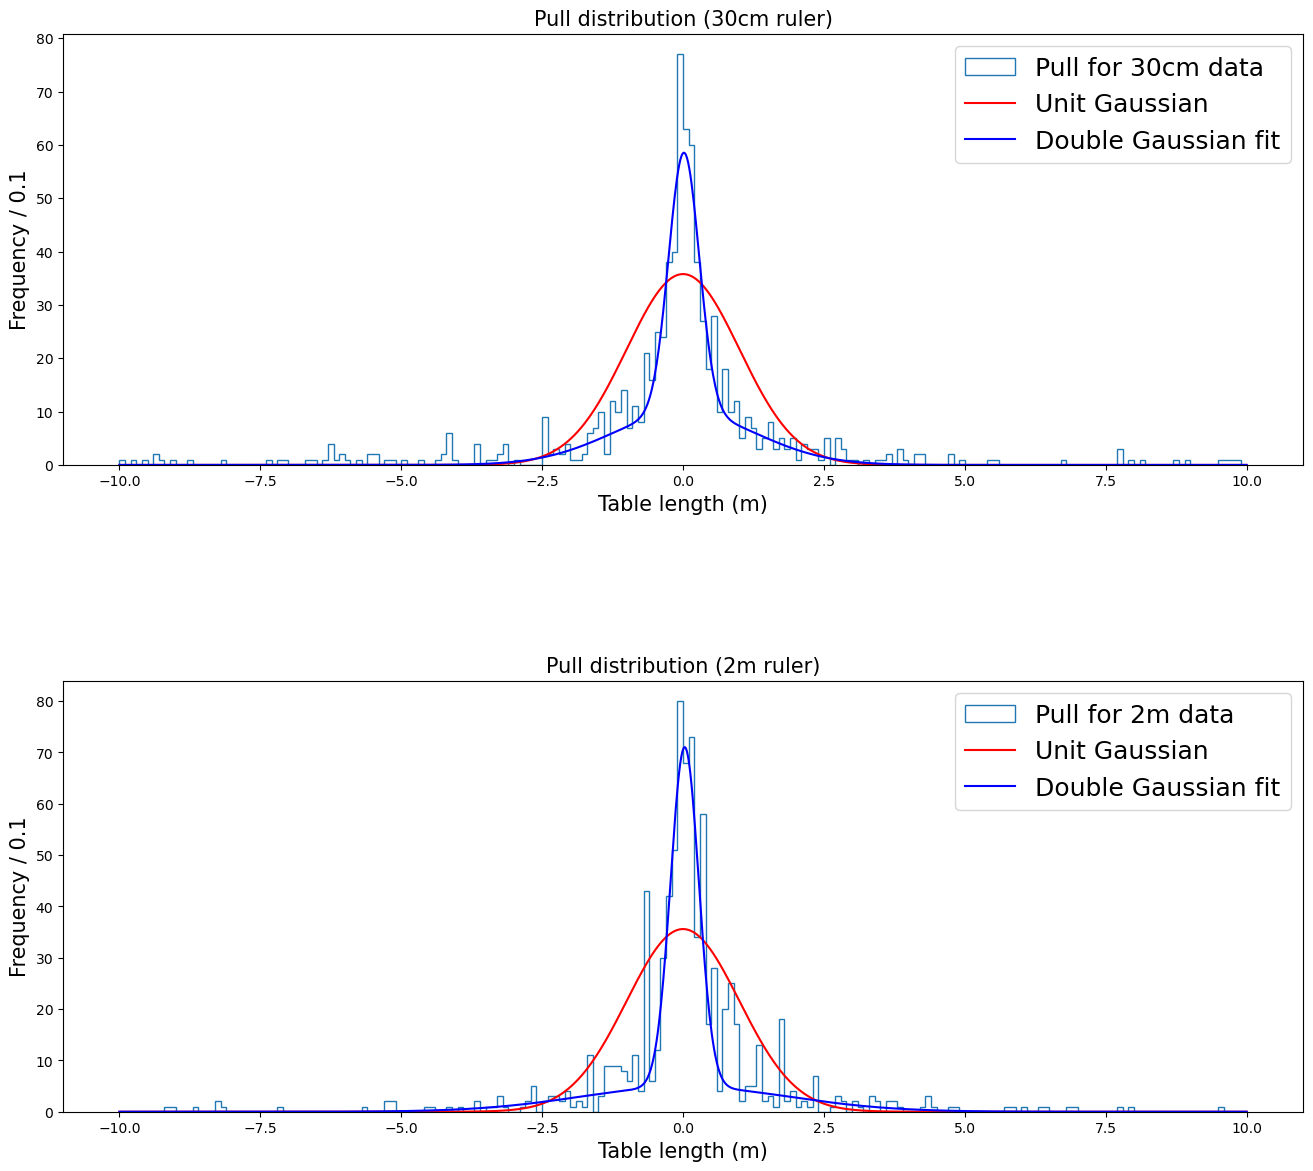

In [27]:

# Define two histograms with all the lengths recorded:
fig_pull, ax_pull = plt.subplots(nrows=2, figsize=(16,14), gridspec_kw={'hspace':0.5})
ax_pullL30cm, ax_pullL2m = ax_pull

hist_pullL30cm = ax_pullL30cm.hist(pull30cm, bins=Nbins, range=(minP, maxP), histtype='step', label='Pull for 30cm data')
ax_pullL30cm.set_title('Pull distribution (30cm ruler)',fontsize=15)
ax_pullL30cm.set_ylabel('Frequency / 0.1',fontsize=15)
ax_pullL30cm.set_xlabel('Table length (m)',fontsize=15)
ax_pullL30cm.plot(xaxis, func_Gaussian(xaxis, len(pull30cm), 0.0, 1.0), '-r', label="Unit Gaussian")
ax_pullL30cm.plot(xaxis, func_G2(xaxis, *mfit30cm_G2.values[:]), '-b', label="Double Gaussian fit")
ax_pullL30cm.legend(fontsize=18)

hist_pullL2m = ax_pullL2m.hist(pull2m, bins=Nbins, range=(minP, maxP), histtype='step', label='Pull for 2m data')
ax_pullL2m.set_title('Pull distribution (2m ruler)',fontsize=15)
ax_pullL2m.set_ylabel('Frequency / 0.1',fontsize=15)
ax_pullL2m.set_xlabel('Table length (m)',fontsize=15)
ax_pullL2m.plot(xaxis, func_Gaussian(xaxis, len(pull2m), 0.0, 1.0), '-r', label="Unit Gaussian")
ax_pullL2m.plot(xaxis, func_G2(xaxis, *mfit2m_G2.values[:]), '-b', label="Double Gaussian fit")
ax_pullL2m.legend(fontsize=18)

fig_raw.tight_layout;

From the pull distribution (i.e. plot of z-value, i.e. how many sigmas they are away from the mean) we see, that while most measurements are quite reasonable, some are highly unlikely. Ideally (if all measurements and uncertainty estimates were correct), the distribution should be unit Gaussian, which it is clearly not. In fact, **most pulls are small, which is caused by an overestimation of the uncertainty**. We are simply conservative and don't trust, that we can do things fairly accurately.

Having seen the distributions, we calculate -- assuming unit Gaussian distributions -- at what level it is reasonable to discard individual measurement based on their z-value, i.e. how many sigmas they are away from the mean. Given that the assumption is not really fulfilled, the real level should probably be set below this value (as many values with low $z$ will make the ChiSquare unnaturally low).

Once the selection level is fitting, we then discard unlikely events (i.e. beyond a certain number of sigmas) and then proceed to calculate the weighted mean (with error, Chi2, and ProbChi2 of course!).

In [28]:
p_global = 0.05      # We choose that we wants to reject points with a global probability below 5%

# Calculate p_local, and turn this probability into a number of sigmas (two-sided interval, hence division by two):
p_local_30cm = 1.0 - (1.0 - p_global)**(1.0/len(L30cm_valid_w))
p_local_2m   = 1.0 - (1.0 - p_global)**(1.0/len(L2m_valid_w))
Nsigma_30cm = np.abs(stats.norm.ppf(p_local_30cm/2.0))
Nsigma_2m   = np.abs(stats.norm.ppf(p_local_2m/2.0))
print(f"   Local p (30cm) = {p_local_30cm:8.6f}    Number of sigmas (two-sided) = {Nsigma_30cm:5.3f}")
print(f"   Local p (2m)   = {p_local_2m:8.6f}    Number of sigmas (two-sided) = {Nsigma_2m:5.3f}")

   Local p (30cm) = 0.000057    Number of sigmas (two-sided) = 4.024
   Local p (2m)   = 0.000058    Number of sigmas (two-sided) = 4.023


In [34]:
# As initial estimate of the mean, we use the unweighted cleaned result:
mask30cm_w = np.abs(L30cm_valid_w-np.mean(L30cm_cleaned_uw))/eL30cm_valid_w < Nsigma_30cm * 0.8     # Notice the factor!
L30cm_cleaned_w = np.array(L30cm_valid_w)[mask30cm_w]
eL30cm_cleaned_w = np.array(eL30cm_valid_w)[mask30cm_w]
print(f"  N(valid measurements): {len(L30cm_valid_w):d}    N(accepted measurements): {len(L30cm_cleaned_w):d}")

# Inspecting all measurement:
for x, e, m in zip(L30cm_valid_w, eL30cm_valid_w, mask30cm_w) :
    # print(f"  {x:7.3f}    {e:7.3f}    {(x-np.mean(L30cm_cleaned_uw))/e:7.2f}   {m}")
    if (m == False) :
        print(f"  Warning! Large pull: L = {x:5.3f} +- {e:5.3f} m     z = {(x-np.mean(L30cm_cleaned_uw))/e:7.2f}")

wmean30cm, ewmean30cm, chi2_wmean30cm, prob_wmean30cm = WeightedAverage(L30cm_cleaned_w, eL30cm_cleaned_w)
print(f"  Weighted Mean = {wmean30cm:7.5f} +- {ewmean30cm:7.5f} m      with   " +
      f"  Prob(chi2={chi2_wmean30cm:5.1f}, Ndof={len(L30cm_cleaned_w)-1:d}) = {prob_wmean30cm:7.5f}")

  N(valid measurements): 897    N(accepted measurements): 721
  Warning! Large pull: L = 3.750 +- 0.013 m     z =   25.98
  Warning! Large pull: L = 3.697 +- 0.020 m     z =   14.24
  Warning! Large pull: L = 3.323 +- 0.009 m     z =   -9.91
  Warning! Large pull: L = 2.815 +- 0.091 m     z =   -6.56
  Warning! Large pull: L = 3.250 +- 0.002 m     z =  -81.11
  Warning! Large pull: L = 3.395 +- 0.005 m     z =   -3.45
  Warning! Large pull: L = 2.422 +- 0.005 m     z = -198.05
  Warning! Large pull: L = 3.753 +- 0.010 m     z =   34.08
  Warning! Large pull: L = 3.425 +- 0.003 m     z =    4.26
  Warning! Large pull: L = 3.085 +- 0.070 m     z =   -4.67
  Warning! Large pull: L = 3.115 +- 0.023 m     z =  -12.92
  Warning! Large pull: L = 3.595 +- 0.005 m     z =   36.55
  Warning! Large pull: L = 3.701 +- 0.030 m     z =    9.63
  Warning! Large pull: L = 1.405 +- 0.030 m     z =  -66.91
  Warning! Large pull: L = 3.356 +- 0.009 m     z =   -6.25
  Warning! Large pull: L = 3.089 +- 0.

#### Note:

For the 30cm case it seems that 9 measurements are at the very edge of the ~4$\sigma$ requirement, and contribute about 133 to the ChiSquare. This can also be seen in the figure above.

For this reason, I **choose** to set the cleaning requirement at 80% (90% for 2m) of the value originally suggested (i.e. around 3.2$\sigma$) by the assumption that the pull of the measurements follow a unit Gaussian, as it is clearly not Gaussian.

In [35]:
# As initial estimate of the mean, we use the unweighted cleaned result:
mask2m_w = np.abs(L2m_valid_w-np.mean(L2m_accepted_uw))/eL2m_valid_w < Nsigma_2m * 0.9     # Notice the factor!
L2m_cleaned_w = np.array(L2m_valid_w)[mask2m_w]
eL2m_cleaned_w = np.array(eL2m_valid_w)[mask2m_w]
print(f"  N(valid measurements): {len(L2m_valid_w):d}    N(accepted measurements): {len(L2m_cleaned_w):d}")

# Inspecting all measurement:
for x, e, m in zip(L2m_valid_w, eL2m_valid_w, mask2m_w) :
    # print(f"  {x:7.3f}    {e:7.3f}    {(x-np.mean(L2m_accepted_uw))/e:7.2f}   {m}")
    if (m == False) :
        print(f"  Warning! Large pull: L = {x:5.3f} +- {e:5.3f} m     z = {(x-np.mean(L2m_accepted_uw))/e:7.2f}")
        
wmean2m, ewmean2m, chi2_wmean2m, prob_wmean2m = WeightedAverage(L2m_cleaned_w, eL2m_cleaned_w)
print(f"  Weighted Mean = {wmean2m:7.5f} +- {ewmean2m:7.5f} m      with   " +
      f"  Prob(chi2={chi2_wmean2m:5.1f}, Ndof={len(L2m_cleaned_w)-1:d}) = {prob_wmean2m:7.5f}")

  N(valid measurements): 892    N(accepted measurements): 790
  Warning! Large pull: L = 3.696 +- 0.050 m     z =    6.93
  Warning! Large pull: L = 3.371 +- 0.005 m     z =    4.35
  Warning! Large pull: L = 2.350 +- 0.015 m     z =  -66.62
  Warning! Large pull: L = 3.746 +- 0.020 m     z =   19.84
  Warning! Large pull: L = 3.051 +- 0.002 m     z = -149.13
  Warning! Large pull: L = 2.350 +- 0.001 m     z = -999.25
  Warning! Large pull: L = 1.351 +- 0.020 m     z =  -99.91
  Warning! Large pull: L = 3.122 +- 0.025 m     z =   -9.09
  Warning! Large pull: L = 3.631 +- 0.006 m     z =   46.96
  Warning! Large pull: L = 3.535 +- 0.005 m     z =   37.15
  Warning! Large pull: L = 1.350 +- 0.010 m     z = -199.93
  Warning! Large pull: L = 4.550 +- 0.023 m     z =   52.21
  Warning! Large pull: L = 3.322 +- 0.001 m     z =  -27.25
  Warning! Large pull: L = 3.166 +- 0.020 m     z =   -9.16
  Warning! Large pull: L = 3.344 +- 0.001 m     z =   -5.25
  Warning! Large pull: L = 3.653 +- 0.

## Comparing weighted results:

In [36]:
print(f"  Estimate using accepted data (30 cm ruler):    " +
      f"  {wmean30cm:.5f} +- {ewmean30cm:.5f} m       (Nmeasurements = {len(L30cm_cleaned_uw):3d})")
print(f"  Estimate using accepted data (2m folding rule):" +
      f"  {wmean2m:.5f} +- {ewmean2m:.5f} m       (Nmeasurements = {len(L2m_accepted_uw):3d})")

  Estimate using accepted data (30 cm ruler):      3.41300 +- 0.00027 m       (Nmeasurements = 677)
  Estimate using accepted data (2m folding rule):  3.34985 +- 0.00011 m       (Nmeasurements = 779)


In [41]:
# Difference before unblinding:
wdiff  = wmean30cm-wmean2m
ewdiff = np.sqrt(ewmean30cm**2 + ewmean2m**2)
wdiffNsig = np.abs(wdiff) / ewdiff
wdiffProb = special.erfc(wdiffNsig / np.sqrt(2))
print(f"  Weighted:   L30cm - L2m (fully blinded)     = {wdiff:8.5f} +- {ewdiff:.5f} m   ({wdiffNsig:3.1f} sigma -> prob={wdiffProb:6.4f})")

# Difference partially unblinded:
wdiff  = wmean30cm-wmean2m - (blinding30cm-blinding2m)
ewdiff = np.sqrt(ewmean30cm**2 + ewmean2m**2)
wdiffNsig = np.abs(wdiff) / ewdiff
wdiffProb = special.erfc(wdiffNsig / np.sqrt(2))
print(f"  Weighted:   L30cm - L2m (partially blinded) = {wdiff:8.5f} +- {ewdiff:.5f} m   ({wdiffNsig:5.1f} sigma -> prob={wdiffProb:6.4f})")

  Weighted:   L30cm - L2m (fully blinded)     =  0.06315 +- 0.00029 m   (215.8 sigma -> prob=0.0000)
  Weighted:   L30cm - L2m (partially blinded) = -0.00034 +- 0.00029 m   (  1.2 sigma -> prob=0.2386)


## Comparing unweighted and weighted results:

In [43]:
# Difference before unblinding:
wdiff  = uwmean30cm - wmean30cm
ewdiff = np.sqrt(euwmean30cm**2 + ewmean30cm**2)
wdiffNsig = np.abs(wdiff) / ewdiff
wdiffProb = special.erfc(wdiffNsig / np.sqrt(2))
print(f"  30cm:  Unweighted - Weighted = {wdiff:8.5f} +- {ewdiff:.5f} m   ({wdiffNsig:3.1f} sigma -> prob={wdiffProb:6.4f})")

# Difference before unblinding:
wdiff  = uwmean2m - wmean2m
ewdiff = np.sqrt(euwmean2m**2 + ewmean2m**2)
wdiffNsig = np.abs(wdiff) / ewdiff
wdiffProb = special.erfc(wdiffNsig / np.sqrt(2))
print(f"  2m:    Unweighted - Weighted = {wdiff:8.5f} +- {ewdiff:.5f} m   ({wdiffNsig:3.1f} sigma -> prob={wdiffProb:6.4f})")

  30cm:  Unweighted - Weighted = -0.00110 +- 0.00056 m   (2.0 sigma -> prob=0.0477)
  2m:    Unweighted - Weighted = -0.00042 +- 0.00023 m   (1.9 sigma -> prob=0.0624)


# The quick and dirty solution(s):

The above analysis is some work, but once you get the hang of it, and have previous produced (or copied understood) code for the task, it is less cumbersome. Once you see a plot of the data and understand what is happening, **the essense of this data analysis is to only consider the reasonable measurements** and extract a value from these.

The below code does that in a quick and dirty manner, which fails to do all the checks that are needed, if the data is important and the situation calls for it.

In [38]:
# Looking at the initial (30cm in particular) plots, it is clear that there is a central peak of valid measurements.
# By eye, the 30cm / 2m peak is at 3.415m / 3.350m (blinded!) and the width about 2.5cm / 1cm, so discarting all measurements
# outside +- 7.5cm / 3cm is a crude but fast way forward.
m30cm = np.abs(L30cm - 3.415) < 0.075
mu30cm = np.mean(np.array(L30cm)[m30cm])
sig30cm = np.std(np.array(L30cm)[m30cm])
print(f"  The crude (unweighted) mean = {mu30cm:7.5f} +- {sig30cm/np.sqrt(len(L30cm)):7.5f} m" +
      f"  (brutally raw (gu)estimate) from {len(np.array(L30cm)[m30cm]):d} measurements")

m2m = np.abs(L2m - 3.350) < 0.030
mu2m = np.mean(np.array(L2m)[m2m])
sig2m = np.std(np.array(L2m)[m2m])
print(f"  The crude (unweighted) mean = {mu2m:7.5f} +- {sig2m/np.sqrt(len(L2m)):7.5f} m" +
      f"  (brutally raw (gu)estimate) from {len(np.array(L2m)[m2m]):d} measurements")

  The crude (unweighted) mean = 3.41055 +- 0.00057 m  (brutally raw (gu)estimate) from 705 measurements
  The crude (unweighted) mean = 3.34932 +- 0.00022 m  (brutally raw (gu)estimate) from 801 measurements


However, this is approach is not advicable. Give it a little more consideration, and **promise yourself that you'll at the very minimum always do the following three key things**:
1. Blind the data
2. Plot the data
3. Make reassuring cross check and info print statements throughout your code.

By doing these things, you might only have to debug your way out of the unforeseen (e.g. negative uncertainties) to get to a decent result, that you can convince yourself and others is in the right ballpark. Good luck.

**Notice that even though there has been a lot of analysis, comparison, and discussion of the result, the actual value of the table length has not yet been unblinded!**

***

# Questions:

1. Consider the mean, standard deviation, and uncertainty on the mean. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

_Example solution 1_: Not at all precise enough! The standard deviation (i.e. estimate of single measurement precision) is more than 20 cm. Clearly, some of the measurements are very bad, ruining the "naive" mean.

2. Do any of the measurements looks wrong/bad/suspicious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss with your peers, and then each do what you think most justified/best. It somehow boils down to how far away a measurement is from the expectation.
Apply the criterion you find fitting to the list of measurements, and perhaps produce a new list with your accepted and possibly corrected measurements in (to save the original data). How many measurements did you throw away in the end?

_Example solution 2_: There are smaller but obvious peaks at +-30cm due to measurement mistakes (maybe even some at +-60cm). You can exclude them, correct them, or fit multiple Gaussians and take into account the highest peak for the table length. You can take for example 3.5 sigma as a limit (since we expect 0.4 data points there) and discard everything outside of that interval. This deletes a sizable fraction of the data points.

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. What would be your strategy for choosing a range? Is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision and rounded the result?

_Example solution 3_: Fitting with multiple Gaussians (or a Gaussian in a smaller range) gives a much better result. The histogram is not perfectly Gaussian, there are higher peaks for every zero'th cm, coming from people who rounded their estimate. The p-values for my Gaussian fits are not good, indicating that it might not be similar enough to a Gaussian. However, given the data and understanding that it is not perfectly continuous, we will have to live with that.

4. Once you have selected the measurements you want to use, calculate the mean, RMS and uncertainty on the mean. How much did your result improve in precision from the raw data in Q1?

_Example solution 4_: Using the tripple peak method: mean = 3.366 +/- 0.00040 and RMS = 0.003 +/- 0.00042. The improved precision in the RMS is 0.203/0.003 = a factor of 68. You would need 4624 measurements to improve that much!

5. The "Pull" distribution is defined as the plot of $z_i = \left(x_i - \mu \right)/\sigma_i$ where $\mu$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the *single measurements* and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull distribution is often used to remove overly precise measurements (those far out on the tails), and afterwards to scale the errors on the remaining measurements to a reasonable level. Consider the pull distribution, and see if any measurements have suspicious uncertainties.

_Example solution 5_: The pull distribution does not look very Gaussian. It is slightly assymetric, and there are many measurements that are a high number of sigma away from the mean. The Gaussian fit matches the distribution poorly. There are too many pull values very close to zero, indicating that people's uncertainty estimates were too large. But there are also too many outliers - people that measured wrongly and have uncertainties that are too small to reflect that.

6. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Do you need to discard more dubious measurements? Did the result improve further in precision?

_Example solution 6_: When calculating the weighted mean with all the data points, the $\chi^2$ is quite bad. When discarding the points outside of 3 sigma the result is a lot better and with a more reasonable probability.

7. Is the number of mismeasurements 30cm below the actual length more common than those 30cm above? Determine the ratio $r_{mis} = N_{30cm~high} / N_{30cm~low}$ including both its statistical uncertainty, and if possible a systematic uncertainty from defining exactly when a measurement is 30cm off.

_Example solution 7_: Pick a range within which you count measurements as too high or too low. Count the number of measurements that belong to each group; $N_{low}$ and $N_{high}$. The error on these counts is calculated by poissonian statistics: $\sqrt{N_{low}}$ and $\sqrt{N_{high}}$. Calculate the ratio of mismeasurements $r_{mis}$. The corresponding error can be found by propagating the uncertainties of $N_{low}$ and $N_{high}$. The systematic uncertainty is associated with the range you pick in which measurements are classified as mismeasurements. Determine standard deviations for your range (pick for example a tight and a loose range), and see how these uncertainties propagate into the ratio (by counting $N_{low}$ and $N_{high}$ and the corresponding $r_{mis}$, for each range). The variation in $r_{mis}$ shows a standard deviation associated with the systamatic uncertainty.<br>
A good alternative solution can be obtained from fitting, as this doesn't require you to choose any range, and you thus avoid the associated systematic uncertainty.


#### Now repeat the above for the 2m folding rule
...and consider all the questions below as optional problems, where you might just try to solve selected problems.
 
***

8. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

_Example solution 8_: Compare the standard deviations from the central peak for the 30cm ruler and the 2m folding ruler case. It should not be a surprise that it is smaller for the 2m folding rule, as this is simply a better device for the measurement.

9. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

_Example solution 9_: Difference: abs(L30cm_weigthed_mean - L2m_weighted_mean). Uncertainty on difference: Propagate errors of the weigthed means into the difference.

Difference in number of sigmas: abs(L30cm_weigthed_mean - L2m_weighted_mean)/sqrt(eL30cm_weigthed_mean^2 + L2m_weighted_mean^2). See how far away this is from zero sigma. This is a standard z-test with two samples.

10. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)

_Example solution 10_: I would probably take the weighted mean (after discarding the outliers) of the 2m ruler, and be convinced further if the 30cm ruler result agrees.


### Advanced questions:

11. Consider the 2020 data files with additional information about which day the measurements were done, and find out if the day has an impact on the quality of the measurements.

12. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?

_Example solution 12_: See if there is a shift in value from the unweighted mean to the weighted mean. If the weighted mean is larger, then people with smaller uncertainties contributed slightly longer measurements of the table. There is in fact such an effect!

# Learning points:

This is a "open" and potentially long exercise, which in essense is meant to illustrate how challeging real data can be, even if it is conceptually simple and in one dimension.

The first learning point is that real data is potentially very complicated, and requires consideration/processing before being as clear cut, as what we simulate. Two approaches could be:
1. A crude/fast *"cut the non-standard (wrong?) measurements away"* analysis, potentially missing something.
2. A detailed *"plot a lot and consider every single point"*, potentially (over-?)using a lot of time.

From this exercise, you should have learned:
1. Always **start by plotting the data**, and ask yourself, if the distributions make sense.
2. In order to remove potential mis-measurements, one uses **Chauvenet's Criterion** and rejects points with a low probability of being correct.
3. Alternatively, one corrects data points (calibration) based on **understanding the reason(s) for these shifts**. 
4. Once the data has been cleaned (distributions Gaussian?), one can apply the usual calculations of mean $\mu$, Standard Deviation $\sigma$, and uncertainty on the mean $\sigma_{\mu}$.
5. When considering **data with uncertainties, the data cleaning is different**, as one considers how far away potential mis-measurements are in units of their uncertainty.
6. **It is always important to have ways of cross checking one's results**, in this case comparing the 30cm ruler with the 2m folding rule result.
7. An alternative method of estimating the length is by fitting the entire distribution with a combination of PDFs (Gaussians). In this way, one avoids excluding data, but rather model the mistakes made.